# True Emotions? Investigating How EU Foreign Policy Reacts to International Norm Violations
## Data acquiring, processing, and statistical analyses

Extract a list of targeted sources

In [1]:
import requests # Downloading webpages
import bs4
from bs4 import BeautifulSoup # Extracting data from html files
import urllib.parse
from urllib.parse import urljoin
import time
from time import sleep # Time management
import tqdm # Processbar
import pathlib
from pathlib import Path # Working with files
import random # Generating pseudo random numbers
import pkg_resources # For citing modules
import selenium
from selenium import webdriver #selenium tools to automate web browsing
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import tensorflow

In [1]:
import requests
import random
from selenium import webdriver #selenium tools to automate web browsing
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import bs4
from bs4 import BeautifulSoup
from urllib.parse import urljoin

In [2]:
EUC_url = 'https://www.consilium.europa.eu/en/press/press-releases/?keyword=Russia&dateFrom=2021%2F02%2F24&dateTo=2024%2F03%2F07'

# Use requests to fetch the initial HTML
EUC_req = requests.get(EUC_url) #This line retrieves URL
EUC_soup = EUC_req.text #Gets all text from URL
#Define needed variables for later use
all_EUC_urls = [] #List to put stuff in
wait_time = random.uniform(2, 5)

#Opens Consilium
driver = webdriver.Chrome()
driver.get(EUC_url)
time.sleep(wait_time)

#Accept cookies
accept_cookie = driver.find_element(by = By.CSS_SELECTOR, value = '[aria-describedby="accept_cookies"]')
accept_cookie.click() 
time.sleep(wait_time)

# Use Selenium to load the page and fetch the complete HTML
for page in range(17): #however many pages of results
    complete_EUC_content = driver.page_source
    parsed_EUC_content = BeautifulSoup(complete_EUC_content, 'html.parser')
    EUC_urls_ugly = parsed_EUC_content.find_all('h3', class_='h5', itemprop="headline") # extracting the links we want. By looking at the page with the inspect feature, we see that all the links we're interested in are classified with h5.
    for h3_element in EUC_urls_ugly:
        a_elements = h3_element.find_all('a', href=True)
        for a_element in a_elements:
            all_EUC_urls.append(urljoin(EUC_url, a_element['href']))
    time.sleep(wait_time)
    next_page = driver.find_element(by = By.CSS_SELECTOR, value = 'li[aria-label="Go to the next page"] > a')
    next_page.click() 

#all_EUC_urls = all_EUC_urls[1:]
#Close the browser window
driver.quit()

In [3]:
# Assuming all_EUC_urls is your list of URLs

print("List of URLs:")
for url in all_EUC_urls:
    print(url)


List of URLs:
https://www.consilium.europa.eu/en/press/press-releases/2021/02/25/ukraine-declaration-by-the-high-representative-on-behalf-of-the-european-union-on-the-illegal-annexation-of-crimea-and-sevastopol/
https://www.consilium.europa.eu/en/press/press-releases/2021/02/25/remarks-by-president-charles-michel-following-the-first-session-of-the-video-conference-of-the-members-of-the-european-council/
https://www.consilium.europa.eu/en/press/press-releases/2021/03/02/global-human-rights-sanctions-regime-eu-sanctions-four-people-responsible-for-serious-human-rights-violations-in-russia/
https://www.consilium.europa.eu/en/press/press-releases/2021/03/02/press-statement-by-president-charles-michel-following-his-meeting-in-eastern-ukraine-with-president-volodymyr-zelenskyy/
https://www.consilium.europa.eu/en/press/press-releases/2021/03/03/remarks-by-president-charles-michel-at-the-press-conference-following-his-meeting-with-president-volodymyr-zelenskyy-in-kyiv/
https://www.consilium.eu

Convert targeted sources into .txt files

In [4]:
i = 1 #needed to number files 
#Retreives text data from all urls
for row in all_EUC_urls:
    driver = webdriver.Chrome()
    driver.get(row)

    #Accept cookies
    accept_cookie = driver.find_element(by = By.CSS_SELECTOR, value = '[aria-describedby="accept_cookies"]')
    accept_cookie.click() 
    time.sleep(wait_time)

    complete_url = driver.page_source
    parsed_complete_url = BeautifulSoup(complete_url, 'html.parser')
    url_date = driver.find_element(by = By.CLASS_NAME, value = 'padding-bottom-0.margin-bottom-20.no-bb') #retreives date and type of media
    url_date = url_date.find_elements(by = By.TAG_NAME, value = 'li')
    url_date = url_date[2]
    url_title = driver.find_element(by = By.CLASS_NAME, value = 'padding-bottom-0.margin-bottom-20.no-bb') #retreives title of source
    url_title = url_title.find_elements(by = By.TAG_NAME, value = 'h1')
    url_title = url_title[0]
    url_text_we = driver.find_element(by = By.CLASS_NAME, value = 'col-md-9.council-left-content-basic.council-flexify') #retrieves main text from urls
    url_text = url_date.text + ' - ' + url_title.text + ''' 
''' + url_text_we.text #concatinates info into a single .txt file
    #Creates new .txt file in designated file location
    file_path = r'C:\Users\sasha\OneDrive\Desktop\EUC_Thesis\EUC_txtfiles\url_' + str(i) + '.txt' #i used here to name file
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(url_text)
    driver.close()
    i += 1 #updated for next file


In [5]:
print(url_date)

<selenium.webdriver.remote.webelement.WebElement (session="c6d2bdae3b0f1ba495a360b273611a67", element="f.DDB939CDD88932F6F430D1A9FCA39358.d.3C9AC18D7BE698DD6D10470EBC9B0707.e.25")>


Extracting Emotion Label Scores from Text

In [1]:
import transformers
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline
import tqdm as notebook_tqdm
import json
import pandas as pd
import os
from dateutil import parser
from datetime import datetime

c:\Users\sasha\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
emotion = pipeline('sentiment-analysis', 
                    model='arpanghoshal/EmoRoBERTa', 
                    return_all_scores= True)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
c:\Users\sasha\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [3]:
def get_overlapping_chunks(text, chunk_size, overlap):
    overlap_chunks = []
    start = 0
    end = chunk_size

    while start < len(text):
        chunk = text[start:end]
        overlap_chunks.append(chunk)
        start = end - overlap
        end = start + chunk_size

    return overlap_chunks

def read_txt_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

In [4]:
i = 1
date_list = []
folder_path = 'C:/EUC_Thesis/EUC_txtfiles'
#Get list of dates for each file

for filename in os.listdir(folder_path):
    file_path = r'C:/EUC_Thesis/EUC_txtfiles/url_' + str(i) + '.txt'
    if not os.path.exists(file_path):
        break
    with open(file_path, 'r', encoding='utf-8') as file:
        # Read the first line
        first_line = file.readline()
        #Split the line into words
        words = first_line.split()
        #Grab 1st 3 words
        first_three_words = ' '.join(words[:3])
        
        # Append to the list
        date_list.append(first_three_words)

    i += 1

date_objects = []

for date in date_list:
    date_object = datetime.strptime(date,"%d %B %Y")
    date_objects.append(date_object)

In [5]:
print(len(date_list))
print(date_list)
print(len(date_objects))
print(date_objects)

336
['25 February 2021', '25 February 2021', '2 March 2021', '2 March 2021', '3 March 2021', '16 March 2021', '19 March 2021', '22 March 2021', '22 March 2021', '23 March 2021', '25 March 2021', '25 March 2021', '25 March 2021', '15 April 2021', '18 April 2021', '20 April 2021', '21 April 2021', '26 April 2021', '30 April 2021', '1 May 2021', '15 May 2021', '21 May 2021', '24 May 2021', '25 May 2021', '25 May 2021', '25 May 2021', '27 May 2021', '7 June 2021', '7 June 2021', '9 June 2021', '10 June 2021', '10 June 2021', '21 June 2021', '23 June 2021', '25 June 2021', '25 June 2021', '26 June 2021', '5 July 2021', '7 July 2021', '12 July 2021', '16 July 2021', '23 August 2021', '3 September 2021', '20 September 2021', '19 November 2021', '8 December 2021', '9 December 2021', '13 December 2021', '17 December 2021', '13 January 2022', '26 January 2022', '26 January 2022', '4 February 2022', '16 February 2022', '17 February 2022', '19 February 2022', '20 February 2022', '22 February 2022'

In [6]:
for date_obj in date_objects:
    print(date_obj)

2021-02-25 00:00:00
2021-02-25 00:00:00
2021-03-02 00:00:00
2021-03-02 00:00:00
2021-03-03 00:00:00
2021-03-16 00:00:00
2021-03-19 00:00:00
2021-03-22 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00
2021-03-25 00:00:00
2021-03-25 00:00:00
2021-03-25 00:00:00
2021-04-15 00:00:00
2021-04-18 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-26 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-15 00:00:00
2021-05-21 00:00:00
2021-05-24 00:00:00
2021-05-25 00:00:00
2021-05-25 00:00:00
2021-05-25 00:00:00
2021-05-27 00:00:00
2021-06-07 00:00:00
2021-06-07 00:00:00
2021-06-09 00:00:00
2021-06-10 00:00:00
2021-06-10 00:00:00
2021-06-21 00:00:00
2021-06-23 00:00:00
2021-06-25 00:00:00
2021-06-25 00:00:00
2021-06-26 00:00:00
2021-07-05 00:00:00
2021-07-07 00:00:00
2021-07-12 00:00:00
2021-07-16 00:00:00
2021-08-23 00:00:00
2021-09-03 00:00:00
2021-09-20 00:00:00
2021-11-19 00:00:00
2021-12-08 00:00:00
2021-12-09 00:00:00
2021-12-13 00:00:00
2021-12-17 00:00:00
2022-01-13 00:00:00


In [7]:

date_objects[1] = date_objects[1].replace(minute=1)
date_objects[3] = date_objects[3].replace(minute=1)
date_objects[8] = date_objects[8].replace(minute=1)
date_objects[11] = date_objects[11].replace(minute=1)
date_objects[12] = date_objects[12].replace(minute=2)
date_objects[24] = date_objects[24].replace(minute=1)
date_objects[25] = date_objects[25].replace(minute=2)
date_objects[28] = date_objects[28].replace(minute=1)
date_objects[31] = date_objects[31].replace(minute=1)
date_objects[35] = date_objects[35].replace(minute=1)
date_objects[51] = date_objects[51].replace(minute=1)
date_objects[58] = date_objects[58].replace(minute=1)
date_objects[60] = date_objects[60].replace(minute=1)
date_objects[62] = date_objects[62].replace(minute=1)
date_objects[63] = date_objects[63].replace(minute=2)
date_objects[64] = date_objects[64].replace(minute=3)
date_objects[65] = date_objects[65].replace(minute=4)
date_objects[66] = date_objects[66].replace(minute=5)
date_objects[68] = date_objects[68].replace(minute=1)
date_objects[69] = date_objects[69].replace(minute=2)
date_objects[70] = date_objects[70].replace(minute=3)
date_objects[75] = date_objects[75].replace(minute=1)
date_objects[76] = date_objects[76].replace(minute=2)
date_objects[80] = date_objects[80].replace(minute=1)
date_objects[83] = date_objects[83].replace(minute=1)
date_objects[84] = date_objects[84].replace(minute=2)
date_objects[88] = date_objects[88].replace(minute=1)
date_objects[91] = date_objects[91].replace(minute=1)
date_objects[92] = date_objects[92].replace(minute=2)
date_objects[93] = date_objects[93].replace(minute=3)
date_objects[95] = date_objects[95].replace(minute=1)
date_objects[98] = date_objects[98].replace(minute=1)
date_objects[100] = date_objects[100].replace(minute=1)
date_objects[103] = date_objects[103].replace(minute=1)
date_objects[105] = date_objects[105].replace(minute=1)
date_objects[106] = date_objects[106].replace(minute=2)
date_objects[107] = date_objects[107].replace(minute=3)
date_objects[117] = date_objects[117].replace(minute=1)
date_objects[120] = date_objects[120].replace(minute=1)
date_objects[124] = date_objects[124].replace(minute=1)
date_objects[126] = date_objects[126].replace(minute=1)
date_objects[128] = date_objects[128].replace(minute=1)
date_objects[130] = date_objects[130].replace(minute=1)
date_objects[134] = date_objects[134].replace(minute=1)
date_objects[137] = date_objects[137].replace(minute=1)
date_objects[138] = date_objects[138].replace(minute=2)
date_objects[145] = date_objects[145].replace(minute=1)
date_objects[147] = date_objects[147].replace(minute=1)
date_objects[149] = date_objects[149].replace(minute=1)
date_objects[155] = date_objects[155].replace(minute=1)
date_objects[158] = date_objects[158].replace(minute=1)
date_objects[162] = date_objects[162].replace(minute=1)
date_objects[164] = date_objects[164].replace(minute=1)
date_objects[170] = date_objects[170].replace(minute=1)
date_objects[173] = date_objects[173].replace(minute=1)
date_objects[174] = date_objects[174].replace(minute=2)
date_objects[177] = date_objects[177].replace(minute=1)
date_objects[195] = date_objects[195].replace(minute=1)
date_objects[196] = date_objects[196].replace(minute=2)
date_objects[201] = date_objects[201].replace(minute=1)
date_objects[205] = date_objects[205].replace(minute=1)
date_objects[206] = date_objects[206].replace(minute=2)
date_objects[208] = date_objects[208].replace(minute=1)
date_objects[209] = date_objects[209].replace(minute=2)
date_objects[211] = date_objects[211].replace(minute=1)
date_objects[217] = date_objects[217].replace(minute=1)
date_objects[223] = date_objects[223].replace(minute=1)
date_objects[227] = date_objects[227].replace(minute=1)
date_objects[232] = date_objects[232].replace(minute=1)
date_objects[233] = date_objects[233].replace(minute=2)
date_objects[238] = date_objects[238].replace(minute=1)
date_objects[239] = date_objects[239].replace(minute=2)
date_objects[242] = date_objects[242].replace(minute=1)
date_objects[243] = date_objects[243].replace(minute=2)
date_objects[245] = date_objects[245].replace(minute=1)
date_objects[254] = date_objects[254].replace(minute=1)
date_objects[260] = date_objects[260].replace(minute=1)
date_objects[264] = date_objects[264].replace(minute=1)
date_objects[269] = date_objects[269].replace(minute=1)
date_objects[271] = date_objects[271].replace(minute=1)
date_objects[275] = date_objects[275].replace(minute=1)
date_objects[281] = date_objects[281].replace(minute=1)
date_objects[290] = date_objects[290].replace(minute=1)
date_objects[294] = date_objects[294].replace(minute=1)
date_objects[302] = date_objects[302].replace(minute=1)
date_objects[308] = date_objects[308].replace(minute=1)
date_objects[309] = date_objects[309].replace(minute=2)
date_objects[315] = date_objects[315].replace(minute=1)
date_objects[316] = date_objects[316].replace(minute=2)
date_objects[318] = date_objects[318].replace(minute=1)
date_objects[330] = date_objects[330].replace(minute=1)
date_objects[335] = date_objects[335].replace(minute=1)

In [8]:
# Specify the chunk size and overlap
chunk_size = 500
overlap = 25
i = 0

data_dict = {}
list_of_dfs = []
# Iterate over all .txt files in the folder
folder_path = 'C:/EUC_Thesis/EUC_txtfiles'

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    # Get text from document
    document = read_txt_file(file_path)

    # Get overlapping chunks
    text_chunks = get_overlapping_chunks(document, chunk_size, overlap)

    # Process each text chunk
    for text in text_chunks:
        # Perform sentiment analysis
        emotion_labels = emotion(text)

        # Extracting labels and scores
        data = [(item['label'], item['score']) for sublist in emotion_labels for item in sublist]

        # Create a DataFrame for the current text chunk
        df = pd.DataFrame(data, columns=['label', 'score'])

        # Append the DataFrame to the list
        list_of_dfs.append(df)

    # Combine DataFrames into one DataFrame
    result_df = pd.concat(list_of_dfs, keys=range(len(list_of_dfs)))

    # Calculate the mean of the specified column across all data frames
    mean_values = result_df.groupby('label')['score'].mean()

    # Create a new DataFrame with the mean values
    mean_df = pd.DataFrame({'label': mean_values.index, 'mean_score': mean_values.values})

    data_dict[date_objects[i]] = {'file_name': filename, 'mean_df': mean_df}
    
    #Increment the loop counter
    i += 1

      # Check if it's the 336th document to terminate the loop
    if i == 336:
        break

    list_of_dfs = []

In [9]:
print(len(data_dict))

336


In [10]:
# Assuming data_dict is your dictionary
source_date_list = []
approval_scores = []
annoyance_scores = []
disapproval_scores = []
optimism_scores = []
disappointment_scores = []
anger_scores = []
disgust_scores = []
fear_scores = []

for date, values in data_dict.items():
    source_date_list.append(date)
    
    # Extract approval and disapproval scores from mean_df
    approval_score = values['mean_df'][values['mean_df']['label'] == 'approval']['mean_score'].values[0]
    annoyance_score = values['mean_df'][values['mean_df']['label'] == 'annoyance']['mean_score'].values[0]
    disapproval_score = values['mean_df'][values['mean_df']['label'] == 'disapproval']['mean_score'].values[0]
    optimism_score = values['mean_df'][values['mean_df']['label'] == 'optimism']['mean_score'].values[0]
    disappointment_score = values['mean_df'][values['mean_df']['label'] == 'disappointment']['mean_score'].values[0]
    anger_score = values['mean_df'][values['mean_df']['label'] == 'anger']['mean_score'].values[0]
    disgust_score = values['mean_df'][values['mean_df']['label'] == 'disgust']['mean_score'].values[0]
    fear_score = values['mean_df'][values['mean_df']['label'] == 'fear']['mean_score'].values[0]
    
    approval_scores.append(approval_score)
    annoyance_scores.append(annoyance_score)
    disapproval_scores.append(disapproval_score)
    optimism_scores.append(optimism_score)
    disappointment_scores.append(disappointment_score)
    anger_scores.append(anger_score)
    disgust_scores.append(disgust_score)
    fear_scores.append(fear_score)

Graphing Results and Correlation/OLS Regression Analysis

C:\Users\sasha\AppData\Local\Temp\ipykernel_4064\2191321337.py:33: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


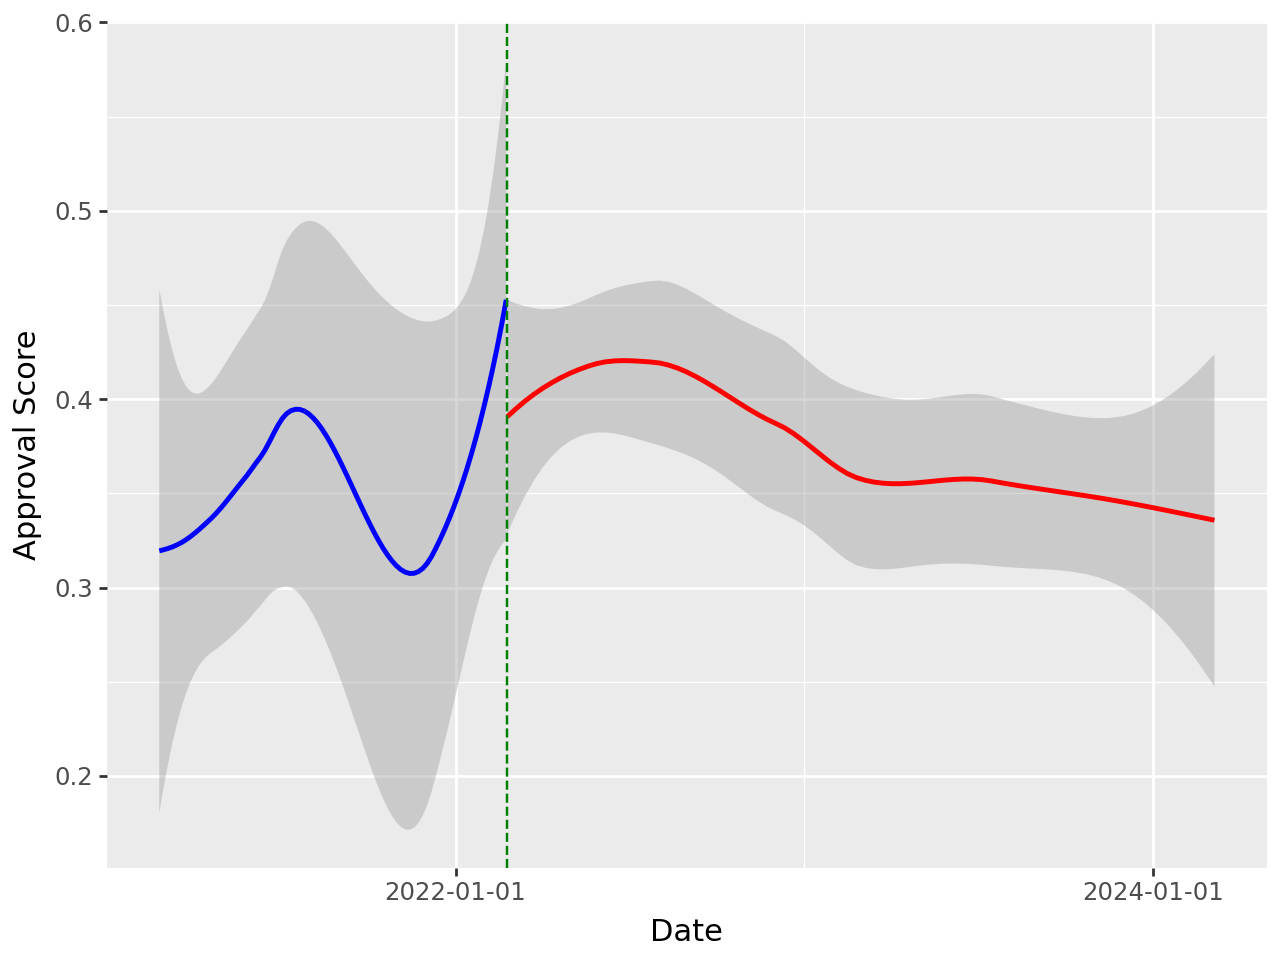

In [12]:
import pandas as pd
from plotnine import ggplot, aes, geom_smooth, geom_vline, labs
from scipy.stats import mannwhitneyu
import numpy as np
import statsmodels.api as sm

#GGPLOT w LOESS smooothing - Approval

# Assuming 'date_objects' and 'emotion_scores' are defined elsewhere
# Create the specific DataFrame
pre_app_df = pd.DataFrame({
    'date': date_objects,
    'approval_score': approval_scores,
})

# Sort the DataFrame by the 'date' column
app_df = pre_app_df.sort_values(by='date')

# Add a column for date_objects and set it to a range of dates based on the length of your emotion scores
app_df['date_objects'] = pd.date_range(start='2021-02-24', periods=len(app_df), freq='D')

# Define the invasion date
invasion_date = '2022-02-24'

# Plotting with LOESS smoothing for before and after invasion on the same graph
plot = ggplot(app_df, aes(x='date', y='approval_score')) + \
       geom_smooth(data=app_df[app_df['date'] < invasion_date], method='loess', se=True, color='blue') + \
       geom_smooth(data=app_df[app_df['date'] >= invasion_date], method='loess', se=True, color='red') + \
       geom_vline(xintercept=invasion_date, linetype='dashed', color='green') + \
       labs(x='Date', y='Approval Score')

# Show the plot
print(plot)


In [13]:
#Approval OLS Regression

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    # Avoid division by zero if all dates are the same
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'approval_scores' are defined elsewhere
# Create the specific DataFrame
pre_app_df = pd.DataFrame({
    'date': date_objects,
    'approval_score': approval_scores,
})

# Sort the DataFrame by the 'date' column
app_df = pre_app_df.sort_values(by='date')

# Standardize the 'date' column
app_df['date_standardized'] = standardize_dates(app_df['date'])

# Perform OLS regression
X = app_df['date_standardized']
X = sm.add_constant(X)
y = app_df['approval_score']
model = sm.OLS(y, X).fit()

# Display model summary
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:         approval_score   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6614
Date:                Mon, 20 May 2024   Prob (F-statistic):              0.417
Time:                        20:40:12   Log-Likelihood:                 75.522
No. Observations:                 336   AIC:                            -147.0
Df Residuals:                     334   BIC:                            -139.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3964      0.02

Coefficients:
const                0.320993
date_standardized    0.356849
interaction          0.128146
interaction_date    -0.468197
dtype: float64

Confidence Intervals for Coefficients:
                          0         1
const              0.245067  0.396918
date_standardized -0.067924  0.781621
interaction        0.024514  0.231778
interaction_date  -0.907000 -0.029394


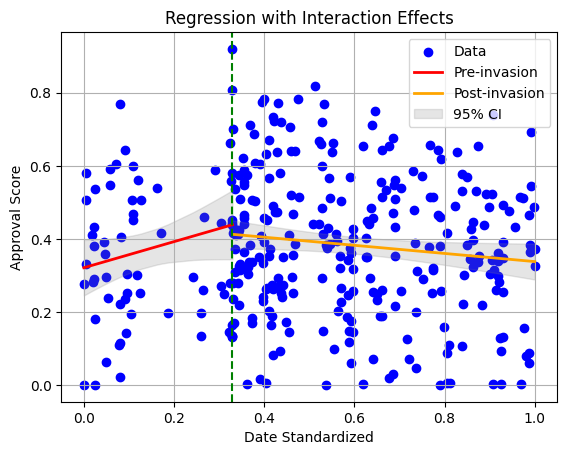

In [12]:
# Approval IE Model

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'approval_scores' are defined elsewhere
# Create the specific DataFrame
pre_app_df = pd.DataFrame({
    'date': date_objects,
    'approval_score': approval_scores,
})

# Sort the DataFrame by the 'date' column
app_df = pre_app_df.sort_values(by='date')

# Standardize the 'date' column
app_df['date_standardized'] = standardize_dates(app_df['date'])

# Define the invasion date as a datetime object
invasion_date = pd.to_datetime('2022-02-24')

# Create a new variable representing the interaction between date and invasion date
app_df['interaction'] = (app_df['date'] > invasion_date).astype(int)

# Perform OLS regression with interaction term
X = app_df[['date_standardized', 'interaction']].copy()
X = sm.add_constant(X)

# Using .loc to avoid SettingWithCopyWarning
X.loc[:, 'interaction_date'] = X['date_standardized'] * X['interaction']
y = app_df['approval_score']
interaction_model = sm.OLS(y, X).fit()

# Extract the coefficients for plotting
coefficients = interaction_model.params

# Display coefficients to check
print("Coefficients:")
print(coefficients)

# Calculate the confidence intervals for the coefficients
confidence_intervals = interaction_model.conf_int()
print("\nConfidence Intervals for Coefficients:")
print(confidence_intervals)

# Calculate the predicted values and confidence intervals based on the interaction model
predictions = interaction_model.get_prediction(X)
app_df['interaction_prediction'] = predictions.predicted_mean
conf_int = predictions.conf_int()

# Plot the scatterplot
plt.scatter(app_df['date_standardized'], y, color='blue', label='Data')

# Plot the pre-invasion regression line
pre_invasion = app_df[app_df['interaction'] == 0]
plt.plot(pre_invasion['date_standardized'], pre_invasion['interaction_prediction'], color='red', linewidth=2, label='Pre-invasion')

# Plot the post-invasion regression line
post_invasion = app_df[app_df['interaction'] == 1]
plt.plot(post_invasion['date_standardized'], post_invasion['interaction_prediction'], color='orange', linewidth=2, label='Post-invasion')

# Plot the confidence intervals
plt.fill_between(app_df['date_standardized'], conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='95% CI')

# Plot a vertical dotted green line at the invasion date
plt.axvline(x=standardize_dates(pd.Series([invasion_date]), app_df['date'].min(), app_df['date'].max()).values[0], color='green', linestyle='--')

plt.title('Regression with Interaction Effects')
plt.xlabel('Date Standardized')
plt.ylabel('Approval Score')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\sasha\AppData\Local\Temp\ipykernel_4184\1489651105.py:27: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


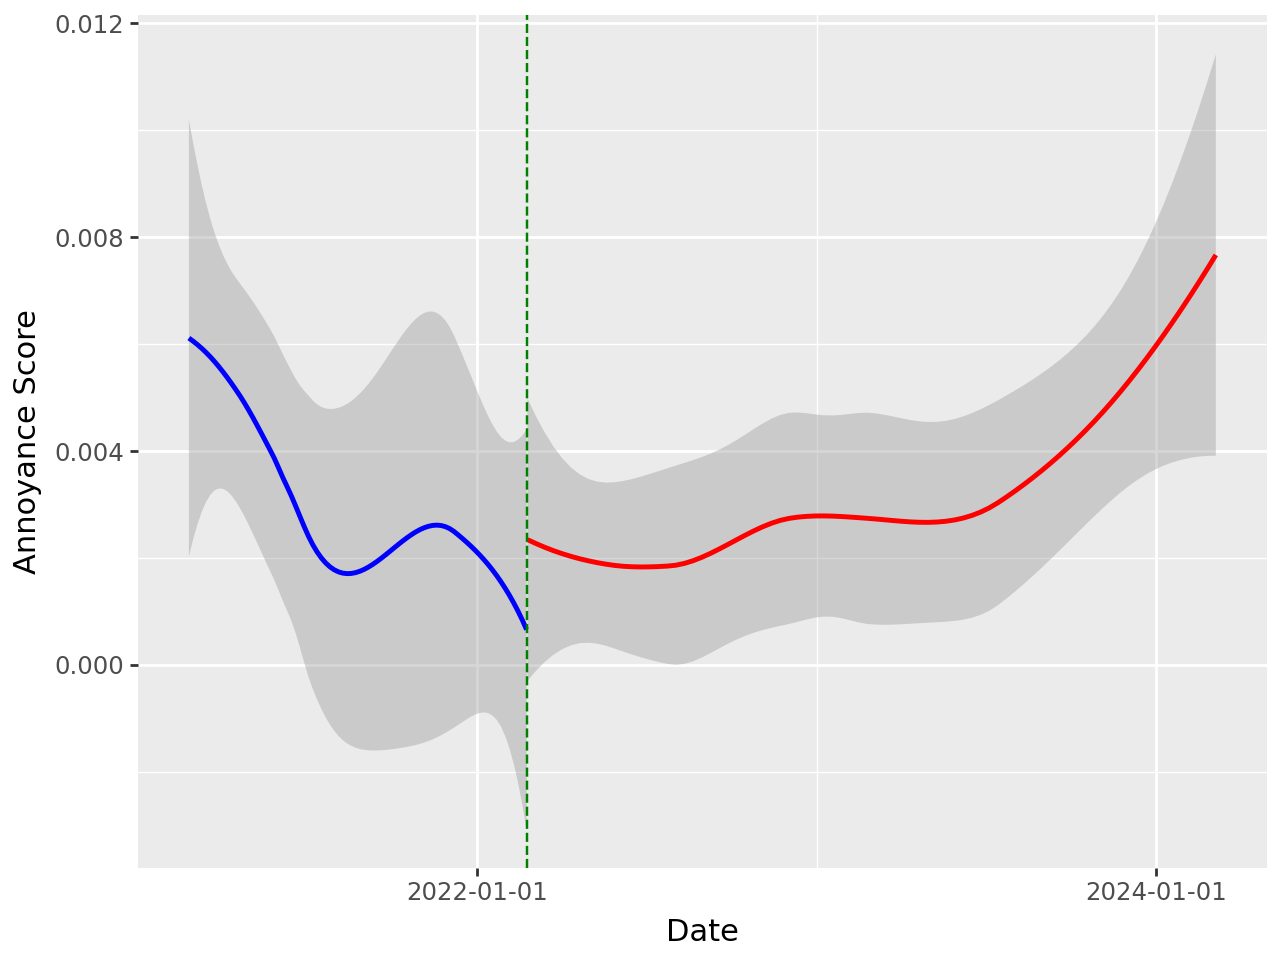

In [20]:
#GGPLOT w LOESS smooothing - Annoyance

# Assuming 'date_objects' and 'emotion_scores' are defined elsewhere
# Create the specific DataFrame
pre_ann_df = pd.DataFrame({
    'date': date_objects,
    'annoyance_score': annoyance_scores,
})

# Sort the DataFrame by the 'date' column
ann_df = pre_ann_df.sort_values(by='date')

# Add a column for date_objects and set it to a range of dates based on the length of your emotion scores
ann_df['date_objects'] = pd.date_range(start='2021-02-24', periods=len(ann_df), freq='D')

# Define the invasion date
invasion_date = '2022-02-24'

# Plotting with LOESS smoothing for before and after invasion on the same graph
plot = ggplot(ann_df, aes(x='date', y='annoyance_score')) + \
       geom_smooth(data=ann_df[ann_df['date'] < invasion_date], method='loess', se=True, color='blue') + \
       geom_smooth(data=ann_df[ann_df['date'] >= invasion_date], method='loess', se=True, color='red') + \
       geom_vline(xintercept=invasion_date, linetype='dashed', color='green') + \
       labs(x='Date', y='Annoyance Score')

# Show the plot
print(plot)


In [16]:
#Annoyance OLS Regression

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    # Avoid division by zero if all dates are the same
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'annoyance_scores' are defined elsewhere
# Create the specific DataFrame
pre_ann_df = pd.DataFrame({
    'date': date_objects,
    'annoyance_score': annoyance_scores,
})

# Sort the DataFrame by the 'date' column
ann_df = pre_ann_df.sort_values(by='date')

# Standardize the 'date' column
ann_df['date_standardized'] = standardize_dates(ann_df['date'])

# Perform OLS regression
X = ann_df['date_standardized']
X = sm.add_constant(X)
y = ann_df['annoyance_score']
model = sm.OLS(y, X).fit()

# Display model summary
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:        annoyance_score   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.408
Date:                Mon, 20 May 2024   Prob (F-statistic):              0.236
Time:                        20:40:29   Log-Likelihood:                 1150.7
No. Observations:                 336   AIC:                            -2297.
Df Residuals:                     334   BIC:                            -2290.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0020      0.00

Coefficients:
const                0.005372
date_standardized   -0.014156
interaction         -0.005897
interaction_date     0.019889
dtype: float64

Confidence Intervals for Coefficients:
                          0         1
const              0.002284  0.008460
date_standardized -0.031434  0.003121
interaction       -0.010113 -0.001682
interaction_date   0.002041  0.037737


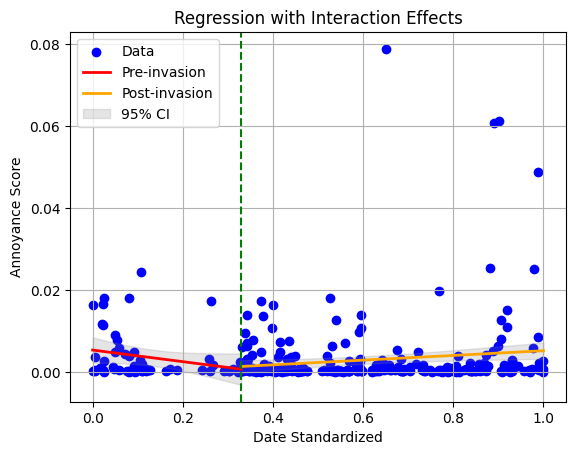

In [13]:
#Annoyance IE Model

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'annoyance_scores' are defined elsewhere
# Create the specific DataFrame
pre_ann_df = pd.DataFrame({
    'date': date_objects,
    'annoyance_score': annoyance_scores,
})

# Sort the DataFrame by the 'date' column
ann_df = pre_ann_df.sort_values(by='date')

# Standardize the 'date' column
ann_df['date_standardized'] = standardize_dates(ann_df['date'])

# Define the invasion date as a datetime object
invasion_date = pd.to_datetime('2022-02-24')

# Create a new variable representing the interaction between date and invasion date
ann_df['interaction'] = (ann_df['date'] > invasion_date).astype(int)

# Perform OLS regression with interaction term
X = ann_df[['date_standardized', 'interaction']].copy()
X = sm.add_constant(X)

# Using .loc to avoid SettingWithCopyWarning
X.loc[:, 'interaction_date'] = X['date_standardized'] * X['interaction']
y = ann_df['annoyance_score']
interaction_model = sm.OLS(y, X).fit()

# Extract the coefficients for plotting
coefficients = interaction_model.params

# Display coefficients to check
print("Coefficients:")
print(coefficients)

# Calculate the confidence intervals for the coefficients
confidence_intervals = interaction_model.conf_int()
print("\nConfidence Intervals for Coefficients:")
print(confidence_intervals)

# Calculate the predicted values and confidence intervals based on the interaction model
predictions = interaction_model.get_prediction(X)
ann_df['interaction_prediction'] = predictions.predicted_mean
conf_int = predictions.conf_int()

# Plot the scatterplot
plt.scatter(ann_df['date_standardized'], y, color='blue', label='Data')

# Plot the pre-invasion regression line
pre_invasion = ann_df[ann_df['interaction'] == 0]
plt.plot(pre_invasion['date_standardized'], pre_invasion['interaction_prediction'], color='red', linewidth=2, label='Pre-invasion')

# Plot the post-invasion regression line
post_invasion = ann_df[ann_df['interaction'] == 1]
plt.plot(post_invasion['date_standardized'], post_invasion['interaction_prediction'], color='orange', linewidth=2, label='Post-invasion')

# Plot the confidence intervals
plt.fill_between(ann_df['date_standardized'], conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='95% CI')

# Plot a vertical dotted green line at the invasion date
plt.axvline(x=standardize_dates(pd.Series([invasion_date]), ann_df['date'].min(), ann_df['date'].max()).values[0], color='green', linestyle='--')

plt.title('Regression with Interaction Effects')
plt.xlabel('Date Standardized')
plt.ylabel('Annoyance Score')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\sasha\AppData\Local\Temp\ipykernel_4184\1884363745.py:27: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


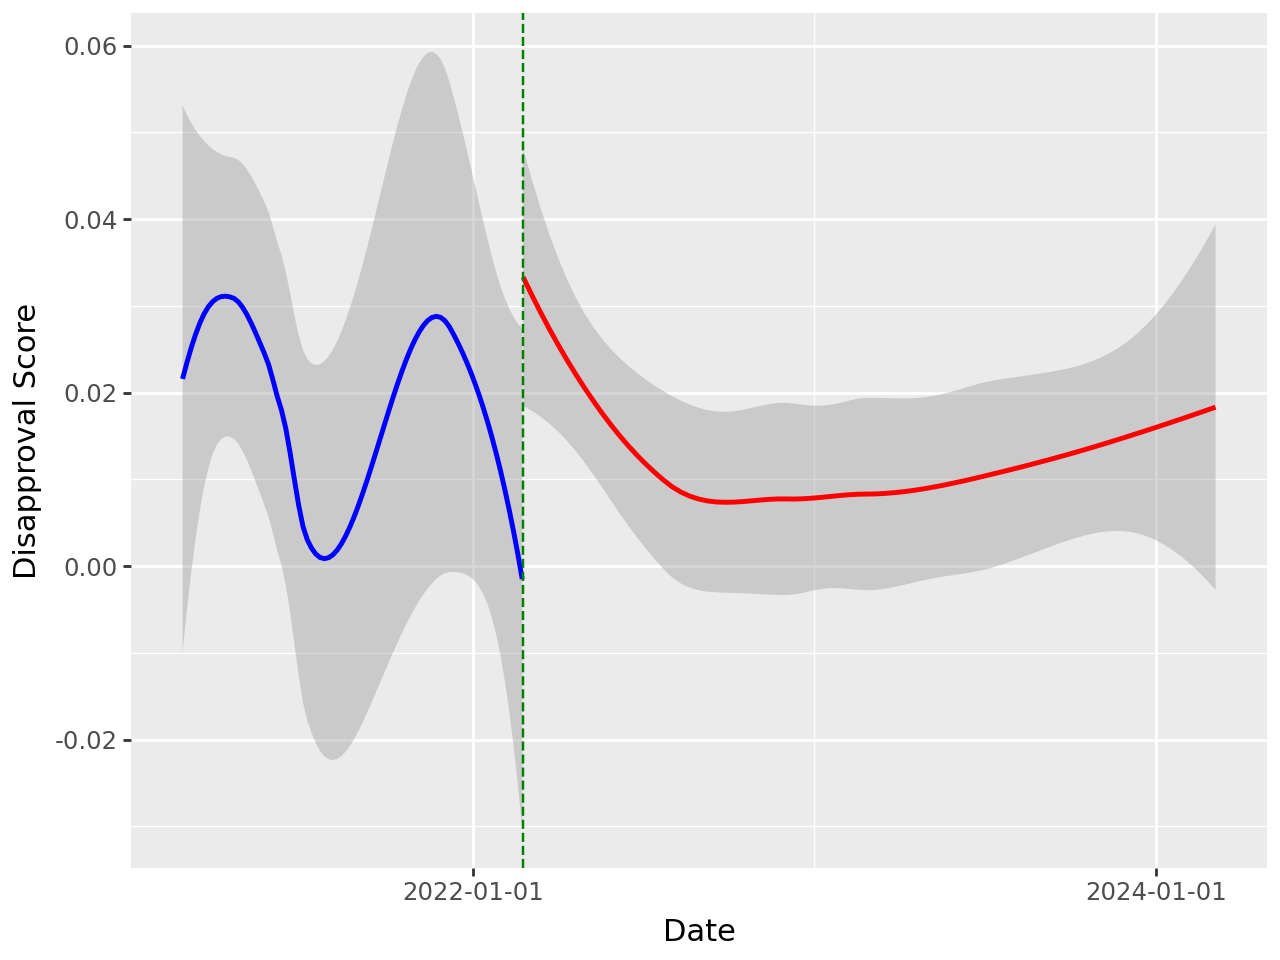

In [26]:
#GGPLOT w LOESS smooothing - Disapproval

# Assuming 'date_objects' and 'emotion_scores' are defined elsewhere
# Create the specific DataFrame
pre_dpv_df = pd.DataFrame({
    'date': date_objects,
    'disapproval_score': disapproval_scores,
})

# Sort the DataFrame by the 'date' column
dpv_df = pre_dpv_df.sort_values(by='date')

# Add a column for date_objects and set it to a range of dates based on the length of your emotion scores
dpv_df['date_objects'] = pd.date_range(start='2021-02-24', periods=len(dpv_df), freq='D')

# Define the invasion date
invasion_date = '2022-02-24'

# Plotting with LOESS smoothing for before and after invasion on the same graph
plot = ggplot(dpv_df, aes(x='date', y='disapproval_score')) + \
       geom_smooth(data=dpv_df[dpv_df['date'] < invasion_date], method='loess', se=True, color='blue') + \
       geom_smooth(data=dpv_df[dpv_df['date'] >= invasion_date], method='loess', se=True, color='red') + \
       geom_vline(xintercept=invasion_date, linetype='dashed', color='green') + \
       labs(x='Date', y='Disapproval Score')

# Show the plot
print(plot)

In [19]:
#Disapproval OLS Regression

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    # Avoid division by zero if all dates are the same
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'disapproval_scores' are defined elsewhere
# Create the specific DataFrame
pre_dpv_df = pd.DataFrame({
    'date': date_objects,
    'disapproval_score': disapproval_scores,
})

# Sort the DataFrame by the 'date' column
dpv_df = pre_dpv_df.sort_values(by='date')

# Standardize the 'date' column
dpv_df['date_standardized'] = standardize_dates(dpv_df['date'])

# Perform OLS regression
X = dpv_df['date_standardized']
X = sm.add_constant(X)
y = dpv_df['disapproval_score']
model = sm.OLS(y, X).fit()

# Display model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      disapproval_score   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.334
Date:                Mon, 20 May 2024   Prob (F-statistic):              0.128
Time:                        20:40:45   Log-Likelihood:                 557.83
No. Observations:                 336   AIC:                            -1112.
Df Residuals:                     334   BIC:                            -1104.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0230      0.00

Coefficients:
const                0.027734
date_standardized   -0.064131
interaction         -0.003051
interaction_date     0.047720
dtype: float64

Confidence Intervals for Coefficients:
                          0         1
const              0.009525  0.045943
date_standardized -0.166002  0.037739
interaction       -0.027904  0.021803
interaction_date  -0.057516  0.152955


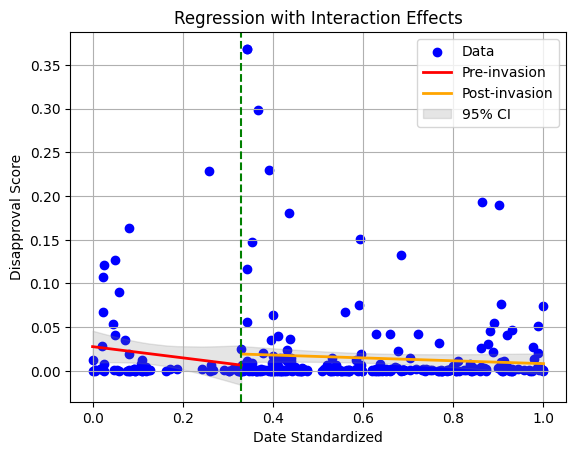

In [14]:
#Disapproval IE Model

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'disapproval_scores' are defined elsewhere
# Create the specific DataFrame
pre_dpv_df = pd.DataFrame({
    'date': date_objects,
    'disapproval_score': disapproval_scores,
})

# Sort the DataFrame by the 'date' column
dpv_df = pre_dpv_df.sort_values(by='date')

# Standardize the 'date' column
dpv_df['date_standardized'] = standardize_dates(dpv_df['date'])

# Define the invasion date as a datetime object
invasion_date = pd.to_datetime('2022-02-24')

# Create a new variable representing the interaction between date and invasion date
dpv_df['interaction'] = (dpv_df['date'] > invasion_date).astype(int)

# Perform OLS regression with interaction term
X = dpv_df[['date_standardized', 'interaction']].copy()
X = sm.add_constant(X)

# Using .loc to avoid SettingWithCopyWarning
X.loc[:, 'interaction_date'] = X['date_standardized'] * X['interaction']
y = dpv_df['disapproval_score']
interaction_model = sm.OLS(y, X).fit()

# Extract the coefficients for plotting
coefficients = interaction_model.params

# Display coefficients to check
print("Coefficients:")
print(coefficients)

# Calculate the confidence intervals for the coefficients
confidence_intervals = interaction_model.conf_int()
print("\nConfidence Intervals for Coefficients:")
print(confidence_intervals)

# Calculate the predicted values and confidence intervals based on the interaction model
predictions = interaction_model.get_prediction(X)
dpv_df['interaction_prediction'] = predictions.predicted_mean
conf_int = predictions.conf_int()

# Plot the scatterplot
plt.scatter(dpv_df['date_standardized'], y, color='blue', label='Data')

# Plot the pre-invasion regression line
pre_invasion = dpv_df[dpv_df['interaction'] == 0]
plt.plot(pre_invasion['date_standardized'], pre_invasion['interaction_prediction'], color='red', linewidth=2, label='Pre-invasion')

# Plot the post-invasion regression line
post_invasion = dpv_df[dpv_df['interaction'] == 1]
plt.plot(post_invasion['date_standardized'], post_invasion['interaction_prediction'], color='orange', linewidth=2, label='Post-invasion')

# Plot the confidence intervals
plt.fill_between(dpv_df['date_standardized'], conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='95% CI')

# Plot a vertical dotted green line at the invasion date
plt.axvline(x=standardize_dates(pd.Series([invasion_date]), dpv_df['date'].min(), dpv_df['date'].max()).values[0], color='green', linestyle='--')

plt.title('Regression with Interaction Effects')
plt.xlabel('Date Standardized')
plt.ylabel('Disapproval Score')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\sasha\AppData\Local\Temp\ipykernel_4184\950289250.py:27: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


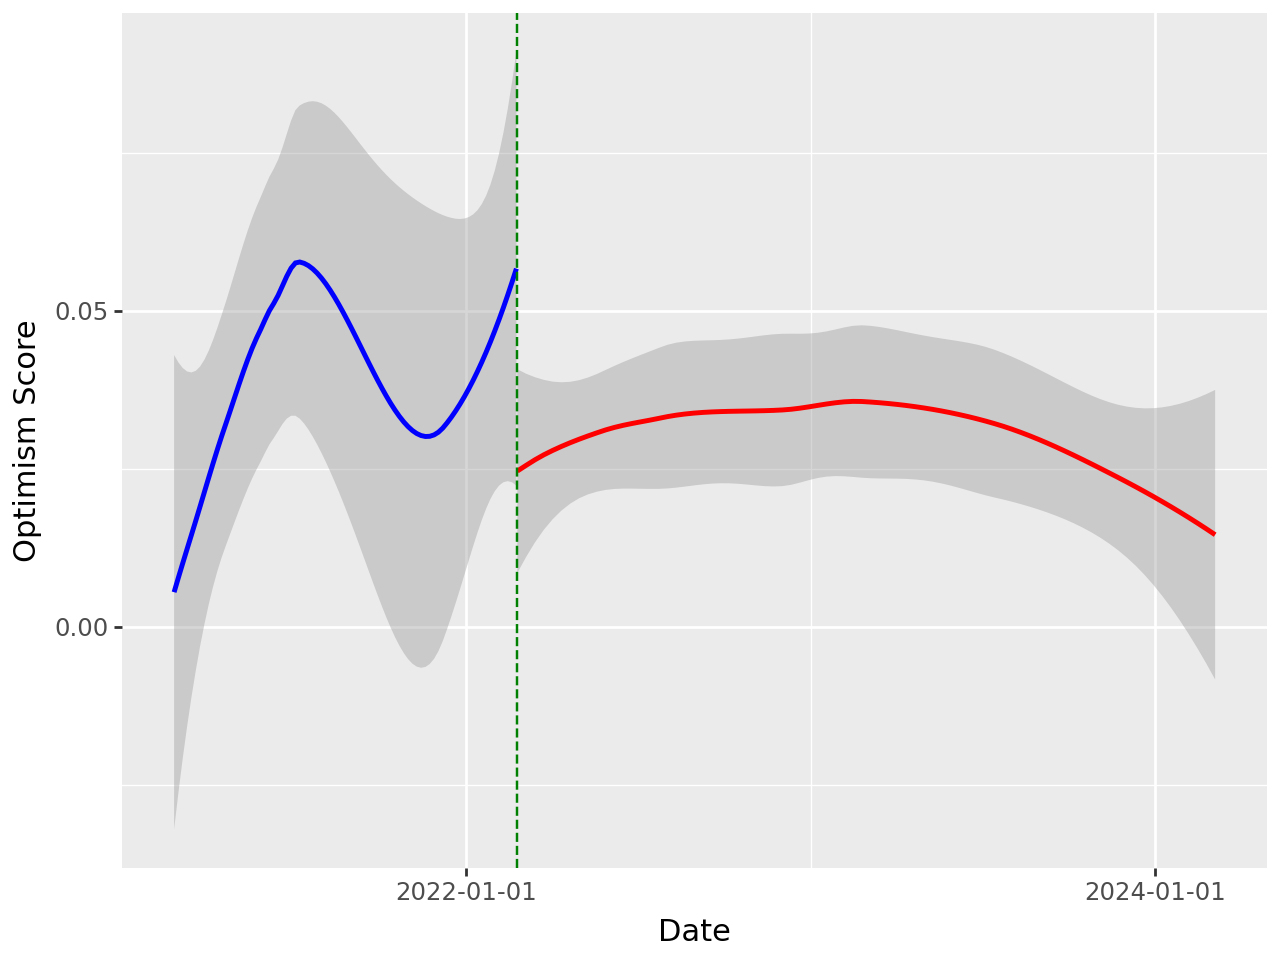

In [33]:
#GGPLOT w LOESS smooothing - Optimism

# Assuming 'date_objects' and 'emotion_scores' are defined elsewhere
# Create the specific DataFrame
pre_opt_df = pd.DataFrame({
    'date': date_objects,
    'optimism_score': optimism_scores,
})

# Sort the DataFrame by the 'date' column
opt_df = pre_opt_df.sort_values(by='date')

# Add a column for date_objects and set it to a range of dates based on the length of your emotion scores
opt_df['date_objects'] = pd.date_range(start='2021-02-24', periods=len(opt_df), freq='D')

# Define the invasion date
invasion_date = '2022-02-24'

# Plotting with LOESS smoothing for before and after invasion on the same graph
plot = ggplot(opt_df, aes(x='date', y='optimism_score')) + \
       geom_smooth(data=opt_df[opt_df['date'] < invasion_date], method='loess', se=True, color='blue') + \
       geom_smooth(data=opt_df[opt_df['date'] >= invasion_date], method='loess', se=True, color='red') + \
       geom_vline(xintercept=invasion_date, linetype='dashed', color='green') + \
       labs(x='Date', y='Optimism Score')

# Show the plot
print(plot)

In [22]:
#Optimism OLS Regression

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    # Avoid division by zero if all dates are the same
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'optimism_scores' are defined elsewhere
# Create the specific DataFrame
pre_opt_df = pd.DataFrame({
    'date': date_objects,
    'optimism_score': optimism_scores,
})

# Sort the DataFrame by the 'date' column
opt_df = pre_opt_df.sort_values(by='date')

# Standardize the 'date' column
opt_df['date_standardized'] = standardize_dates(opt_df['date'])

# Perform OLS regression
X = opt_df['date_standardized']
X = sm.add_constant(X)
y = opt_df['optimism_score']
model = sm.OLS(y, X).fit()

# Display model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         optimism_score   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.078
Date:                Mon, 20 May 2024   Prob (F-statistic):              0.300
Time:                        20:41:00   Log-Likelihood:                 525.93
No. Observations:                 336   AIC:                            -1048.
Df Residuals:                     334   BIC:                            -1040.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0371      0.00

Coefficients:
const                0.027906
date_standardized    0.075090
interaction          0.008234
interaction_date    -0.085226
dtype: float64

Confidence Intervals for Coefficients:
                          0         1
const              0.007925  0.047886
date_standardized -0.036693  0.186873
interaction       -0.019037  0.035506
interaction_date  -0.200701  0.030249


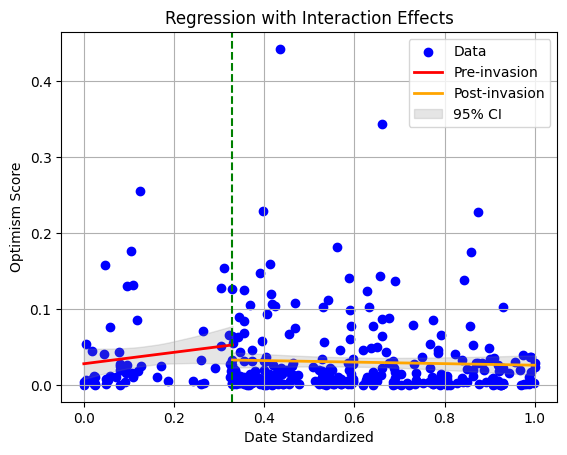

In [15]:
#Optimism IE Model

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'optimism_scores' are defined elsewhere
# Create the specific DataFrame
pre_opt_df = pd.DataFrame({
    'date': date_objects,
    'optimism_score': optimism_scores,
})

# Sort the DataFrame by the 'date' column
opt_df = pre_opt_df.sort_values(by='date')

# Standardize the 'date' column
opt_df['date_standardized'] = standardize_dates(opt_df['date'])

# Define the invasion date as a datetime object
invasion_date = pd.to_datetime('2022-02-24')

# Create a new variable representing the interaction between date and invasion date
opt_df['interaction'] = (opt_df['date'] > invasion_date).astype(int)

# Perform OLS regression with interaction term
X = opt_df[['date_standardized', 'interaction']].copy()
X = sm.add_constant(X)

# Using .loc to avoid SettingWithCopyWarning
X.loc[:, 'interaction_date'] = X['date_standardized'] * X['interaction']
y = opt_df['optimism_score']
interaction_model = sm.OLS(y, X).fit()

# Extract the coefficients for plotting
coefficients = interaction_model.params

# Display coefficients to check
print("Coefficients:")
print(coefficients)

# Calculate the confidence intervals for the coefficients
confidence_intervals = interaction_model.conf_int()
print("\nConfidence Intervals for Coefficients:")
print(confidence_intervals)

# Calculate the predicted values and confidence intervals based on the interaction model
predictions = interaction_model.get_prediction(X)
opt_df['interaction_prediction'] = predictions.predicted_mean
conf_int = predictions.conf_int()

# Plot the scatterplot
plt.scatter(opt_df['date_standardized'], y, color='blue', label='Data')

# Plot the pre-invasion regression line
pre_invasion = opt_df[opt_df['interaction'] == 0]
plt.plot(pre_invasion['date_standardized'], pre_invasion['interaction_prediction'], color='red', linewidth=2, label='Pre-invasion')

# Plot the post-invasion regression line
post_invasion = opt_df[opt_df['interaction'] == 1]
plt.plot(post_invasion['date_standardized'], post_invasion['interaction_prediction'], color='orange', linewidth=2, label='Post-invasion')

# Plot the confidence intervals
plt.fill_between(opt_df['date_standardized'], conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='95% CI')

# Plot a vertical dotted green line at the invasion date
plt.axvline(x=standardize_dates(pd.Series([invasion_date]), opt_df['date'].min(), opt_df['date'].max()).values[0], color='green', linestyle='--')

plt.title('Regression with Interaction Effects')
plt.xlabel('Date Standardized')
plt.ylabel('Optimism Score')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\sasha\AppData\Local\Temp\ipykernel_4184\3367521844.py:27: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


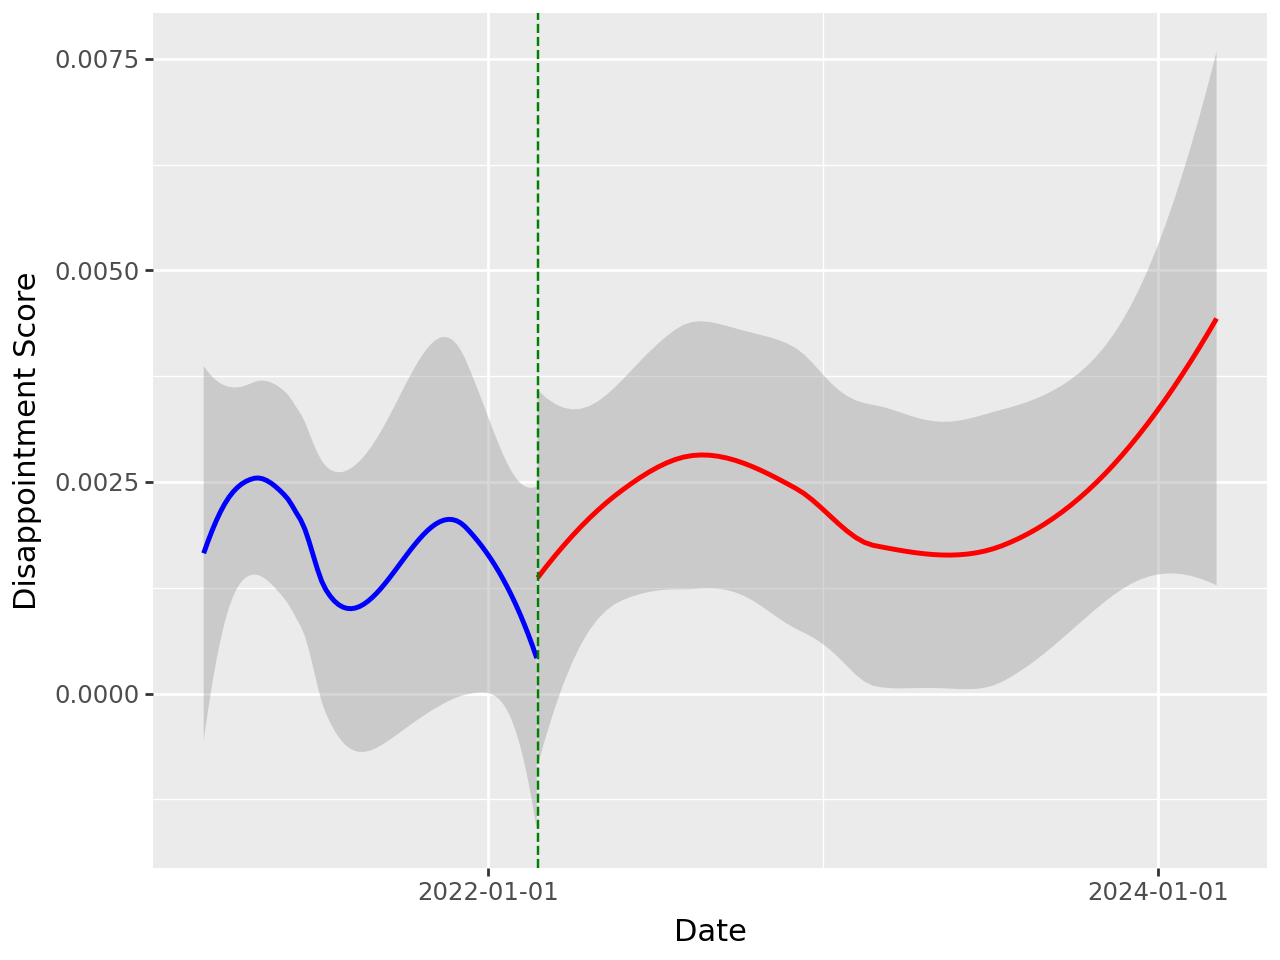

In [38]:
#GGPLOT w LOESS smooothing - Disappointment

# Assuming 'date_objects' and 'emotion_scores' are defined elsewhere
# Create the specific DataFrame
pre_dpn_df = pd.DataFrame({
    'date': date_objects,
    'disappointment_score': disappointment_scores,
})

# Sort the DataFrame by the 'date' column
dpn_df = pre_dpn_df.sort_values(by='date')

# Add a column for date_objects and set it to a range of dates based on the length of your emotion scores
dpn_df['date_objects'] = pd.date_range(start='2021-02-24', periods=len(dpn_df), freq='D')

# Define the invasion date
invasion_date = '2022-02-24'

# Plotting with LOESS smoothing for before and after invasion on the same graph
plot = ggplot(dpn_df, aes(x='date', y='disappointment_score')) + \
       geom_smooth(data=dpn_df[dpn_df['date'] < invasion_date], method='loess', se=True, color='blue') + \
       geom_smooth(data=dpn_df[dpn_df['date'] >= invasion_date], method='loess', se=True, color='red') + \
       geom_vline(xintercept=invasion_date, linetype='dashed', color='green') + \
       labs(x='Date', y='Disappointment Score')

# Show the plot
print(plot)

In [26]:
#Disappointment OLS Regression

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    # Avoid division by zero if all dates are the same
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'disappointment_scores' are defined elsewhere
# Create the specific DataFrame
pre_dpn_df = pd.DataFrame({
    'date': date_objects,
    'disappointment_score': disappointment_scores,
})

# Sort the DataFrame by the 'date' column
dpn_df = pre_dpn_df.sort_values(by='date')

# Standardize the 'date' column
dpn_df['date_standardized'] = standardize_dates(dpn_df['date'])

# Perform OLS regression
X = dpn_df['date_standardized']
X = sm.add_constant(X)
y = dpn_df['disappointment_score']
model = sm.OLS(y, X).fit()

# Display model summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     disappointment_score   R-squared:                       0.002
Model:                              OLS   Adj. R-squared:                 -0.001
Method:                   Least Squares   F-statistic:                    0.6427
Date:                  Mon, 20 May 2024   Prob (F-statistic):              0.423
Time:                          20:42:52   Log-Likelihood:                 1222.1
No. Observations:                   336   AIC:                            -2440.
Df Residuals:                       334   BIC:                            -2433.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             

Coefficients:
const                0.002408
date_standardized   -0.004637
interaction         -0.000968
interaction_date     0.006025
dtype: float64

Confidence Intervals for Coefficients:
                          0         1
const             -0.000115  0.004931
date_standardized -0.018752  0.009479
interaction       -0.004412  0.002476
interaction_date  -0.008557  0.020607


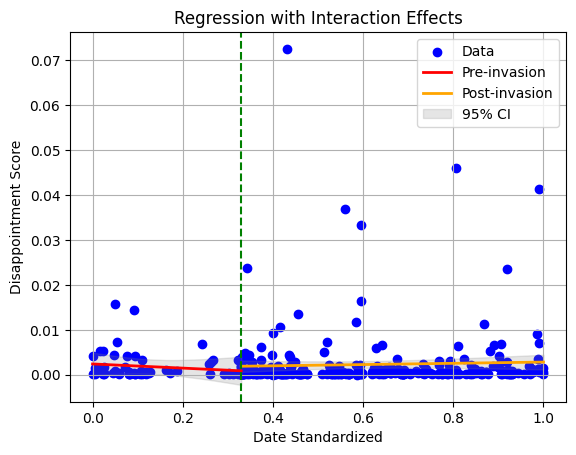

In [16]:
#Disappointment IE Model

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'disappointment_scores' are defined elsewhere
# Create the specific DataFrame
pre_dpn_df = pd.DataFrame({
    'date': date_objects,
    'disappointment_score': disappointment_scores,
})

# Sort the DataFrame by the 'date' column
dpn_df = pre_dpn_df.sort_values(by='date')

# Standardize the 'date' column
dpn_df['date_standardized'] = standardize_dates(dpn_df['date'])

# Define the invasion date as a datetime object
invasion_date = pd.to_datetime('2022-02-24')

# Create a new variable representing the interaction between date and invasion date
dpn_df['interaction'] = (dpn_df['date'] > invasion_date).astype(int)

# Perform OLS regression with interaction term
X = dpn_df[['date_standardized', 'interaction']].copy()
X = sm.add_constant(X)

# Using .loc to avoid SettingWithCopyWarning
X.loc[:, 'interaction_date'] = X['date_standardized'] * X['interaction']
y = dpn_df['disappointment_score']
interaction_model = sm.OLS(y, X).fit()

# Extract the coefficients for plotting
coefficients = interaction_model.params

# Display coefficients to check
print("Coefficients:")
print(coefficients)

# Calculate the confidence intervals for the coefficients
confidence_intervals = interaction_model.conf_int()
print("\nConfidence Intervals for Coefficients:")
print(confidence_intervals)

# Calculate the predicted values and confidence intervals based on the interaction model
predictions = interaction_model.get_prediction(X)
dpn_df['interaction_prediction'] = predictions.predicted_mean
conf_int = predictions.conf_int()

# Plot the scatterplot
plt.scatter(dpn_df['date_standardized'], y, color='blue', label='Data')

# Plot the pre-invasion regression line
pre_invasion = dpn_df[dpn_df['interaction'] == 0]
plt.plot(pre_invasion['date_standardized'], pre_invasion['interaction_prediction'], color='red', linewidth=2, label='Pre-invasion')

# Plot the post-invasion regression line
post_invasion = dpn_df[dpn_df['interaction'] == 1]
plt.plot(post_invasion['date_standardized'], post_invasion['interaction_prediction'], color='orange', linewidth=2, label='Post-invasion')

# Plot the confidence intervals
plt.fill_between(dpn_df['date_standardized'], conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='95% CI')

# Plot a vertical dotted green line at the invasion date
plt.axvline(x=standardize_dates(pd.Series([invasion_date]), dpn_df['date'].min(), dpn_df['date'].max()).values[0], color='green', linestyle='--')

plt.title('Regression with Interaction Effects')
plt.xlabel('Date Standardized')
plt.ylabel('Disappointment Score')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\sasha\AppData\Local\Temp\ipykernel_4184\1152460225.py:27: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


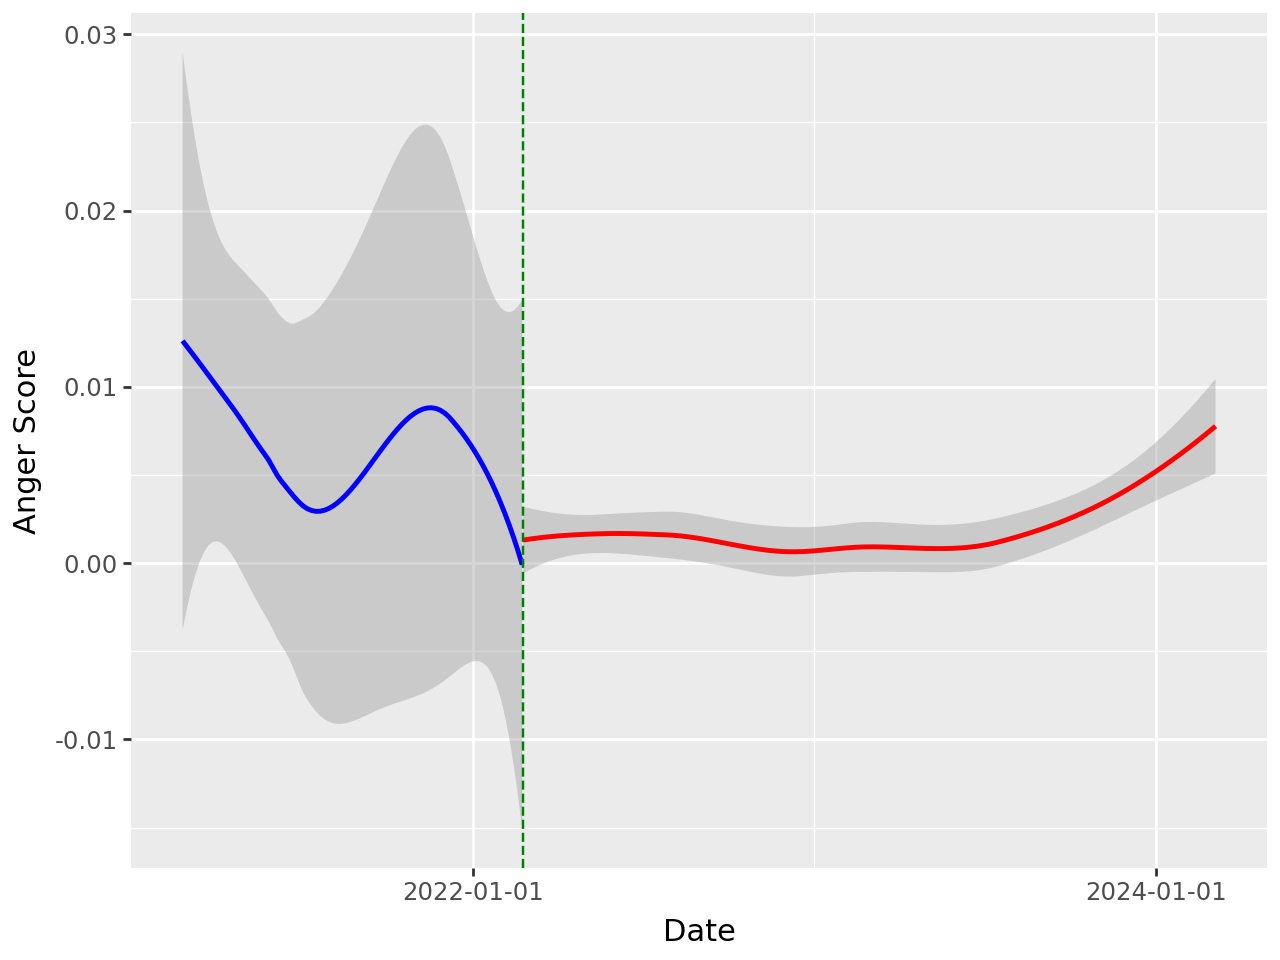

In [43]:
#GGPLOT w LOESS smooothing - Anger

# Assuming 'date_objects' and 'emotion_scores' are defined elsewhere
# Create the specific DataFrame
pre_ang_df = pd.DataFrame({
    'date': date_objects,
    'anger_score': anger_scores,
})

# Sort the DataFrame by the 'date' column
ang_df = pre_ang_df.sort_values(by='date')

# Add a column for date_objects and set it to a range of dates based on the length of your emotion scores
ang_df['date_objects'] = pd.date_range(start='2021-02-24', periods=len(ang_df), freq='D')

# Define the invasion date
invasion_date = '2022-02-24'

# Plotting with LOESS smoothing for before and after invasion on the same graph
plot = ggplot(ang_df, aes(x='date', y='anger_score')) + \
       geom_smooth(data=ang_df[ang_df['date'] < invasion_date], method='loess', se=True, color='blue') + \
       geom_smooth(data=ang_df[ang_df['date'] >= invasion_date], method='loess', se=True, color='red') + \
       geom_vline(xintercept=invasion_date, linetype='dashed', color='green') + \
       labs(x='Date', y='Anger Score')

# Show the plot
print(plot)

In [30]:
#Anger OLS Regression

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    # Avoid division by zero if all dates are the same
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'anger_scores' are defined elsewhere
# Create the specific DataFrame
pre_ang_df = pd.DataFrame({
    'date': date_objects,
    'anger_score': anger_scores,
})

# Sort the DataFrame by the 'date' column
ang_df = pre_ang_df.sort_values(by='date')

# Standardize the 'date' column
ang_df['date_standardized'] = standardize_dates(ang_df['date'])

# Perform OLS regression
X = ang_df['date_standardized']
X = sm.add_constant(X)
y = ang_df['anger_score']
model = sm.OLS(y, X).fit()

# Display model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            anger_score   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.951
Date:                Mon, 20 May 2024   Prob (F-statistic):              0.163
Time:                        20:43:52   Log-Likelihood:                 1040.3
No. Observations:                 336   AIC:                            -2077.
Df Residuals:                     334   BIC:                            -2069.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0044      0.00

Coefficients:
const                0.009604
date_standardized   -0.023379
interaction         -0.010259
interaction_date     0.027586
dtype: float64

Confidence Intervals for Coefficients:
                          0         1
const              0.005343  0.013865
date_standardized -0.047219  0.000461
interaction       -0.016076 -0.004443
interaction_date   0.002959  0.052214


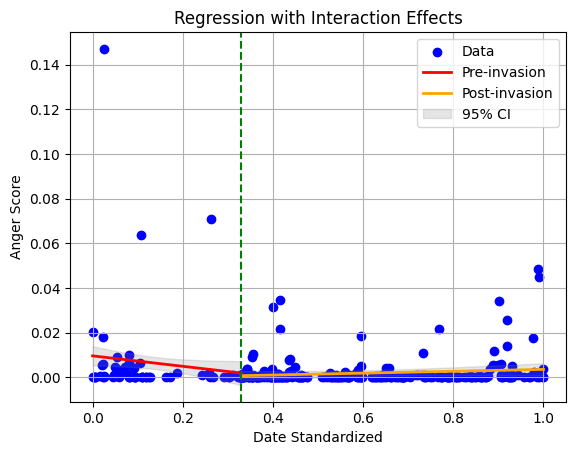

In [17]:
#Anger IE Model

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'anger_scores' are defined elsewhere
# Create the specific DataFrame
pre_ang_df = pd.DataFrame({
    'date': date_objects,
    'anger_score': anger_scores,
})

# Sort the DataFrame by the 'date' column
ang_df = pre_ang_df.sort_values(by='date')

# Standardize the 'date' column
ang_df['date_standardized'] = standardize_dates(ang_df['date'])

# Define the invasion date as a datetime object
invasion_date = pd.to_datetime('2022-02-24')

# Create a new variable representing the interaction between date and invasion date
ang_df['interaction'] = (ang_df['date'] > invasion_date).astype(int)

# Perform OLS regression with interaction term
X = ang_df[['date_standardized', 'interaction']].copy()
X = sm.add_constant(X)

# Using .loc to avoid SettingWithCopyWarning
X.loc[:, 'interaction_date'] = X['date_standardized'] * X['interaction']
y = ang_df['anger_score']
interaction_model = sm.OLS(y, X).fit()

# Extract the coefficients for plotting
coefficients = interaction_model.params

# Display coefficients to check
print("Coefficients:")
print(coefficients)

# Calculate the confidence intervals for the coefficients
confidence_intervals = interaction_model.conf_int()
print("\nConfidence Intervals for Coefficients:")
print(confidence_intervals)

# Calculate the predicted values and confidence intervals based on the interaction model
predictions = interaction_model.get_prediction(X)
ang_df['interaction_prediction'] = predictions.predicted_mean
conf_int = predictions.conf_int()

# Plot the scatterplot
plt.scatter(ang_df['date_standardized'], y, color='blue', label='Data')

# Plot the pre-invasion regression line
pre_invasion = ang_df[ang_df['interaction'] == 0]
plt.plot(pre_invasion['date_standardized'], pre_invasion['interaction_prediction'], color='red', linewidth=2, label='Pre-invasion')

# Plot the post-invasion regression line
post_invasion = ang_df[ang_df['interaction'] == 1]
plt.plot(post_invasion['date_standardized'], post_invasion['interaction_prediction'], color='orange', linewidth=2, label='Post-invasion')

# Plot the confidence intervals
plt.fill_between(ang_df['date_standardized'], conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='95% CI')

# Plot a vertical dotted green line at the invasion date
plt.axvline(x=standardize_dates(pd.Series([invasion_date]), ang_df['date'].min(), ang_df['date'].max()).values[0], color='green', linestyle='--')

plt.title('Regression with Interaction Effects')
plt.xlabel('Date Standardized')
plt.ylabel('Anger Score')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\sasha\AppData\Local\Temp\ipykernel_4184\2952126453.py:27: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


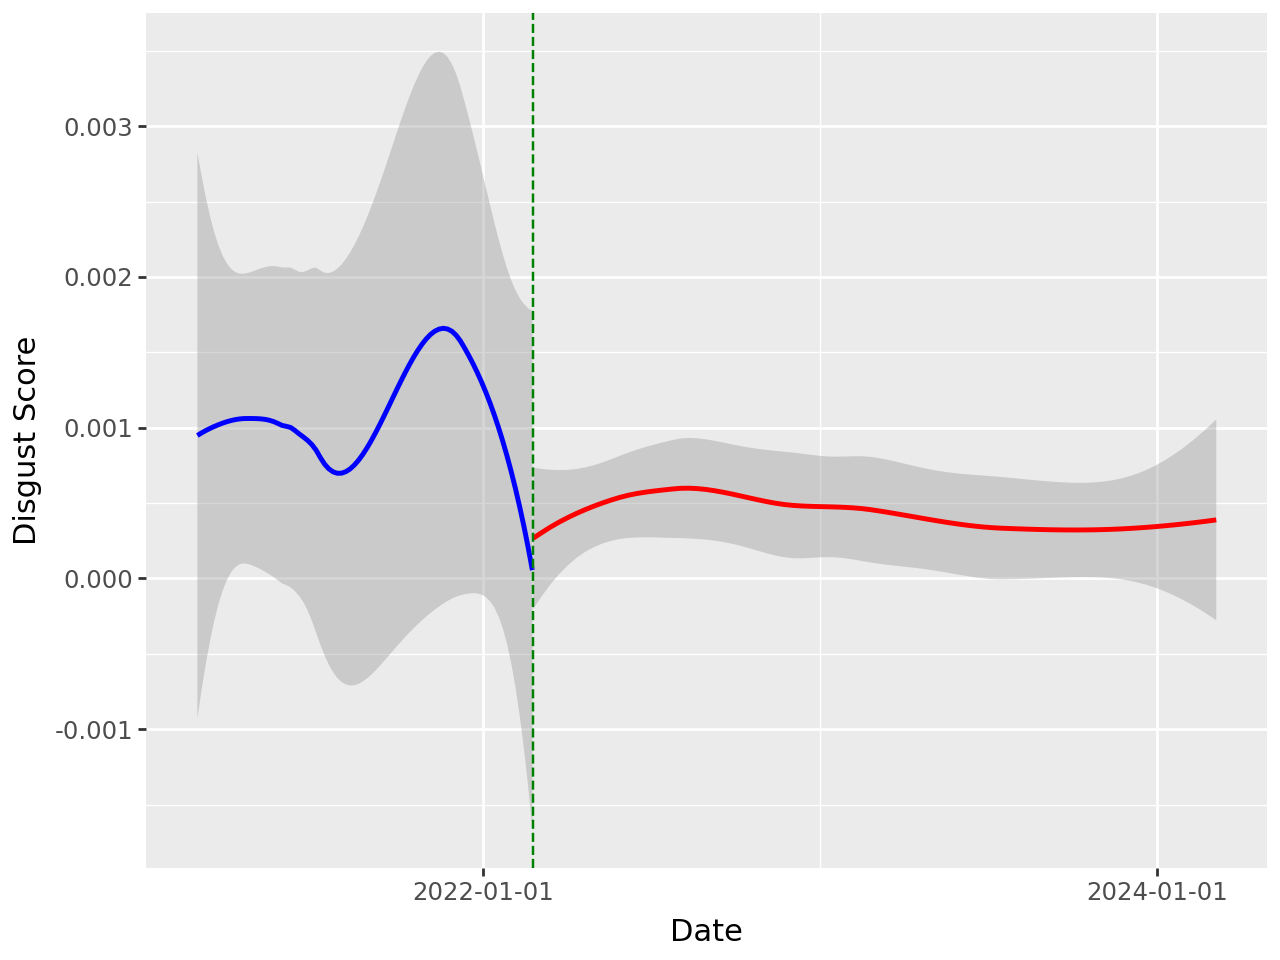

In [49]:
#GGPLOT w LOESS smooothing - Disgust

# Assuming 'date_objects' and 'emotion_scores' are defined elsewhere
# Create the specific DataFrame
pre_gus_df = pd.DataFrame({
    'date': date_objects,
    'disgust_score': disgust_scores,
})

# Sort the DataFrame by the 'date' column
gus_df = pre_gus_df.sort_values(by='date')

# Add a column for date_objects and set it to a range of dates based on the length of your emotion scores
gus_df['date_objects'] = pd.date_range(start='2021-02-24', periods=len(gus_df), freq='D')

# Define the invasion date
invasion_date = '2022-02-24'

# Plotting with LOESS smoothing for before and after invasion on the same graph
plot = ggplot(gus_df, aes(x='date', y='disgust_score')) + \
       geom_smooth(data=gus_df[gus_df['date'] < invasion_date], method='loess', se=True, color='blue') + \
       geom_smooth(data=gus_df[gus_df['date'] >= invasion_date], method='loess', se=True, color='red') + \
       geom_vline(xintercept=invasion_date, linetype='dashed', color='green') + \
       labs(x='Date', y='Disgust Score')

# Show the plot
print(plot)

In [33]:
#Disgust OLS Regression

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    # Avoid division by zero if all dates are the same
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'disgust_scores' are defined elsewhere
# Create the specific DataFrame
pre_gus_df = pd.DataFrame({
    'date': date_objects,
    'disgust_score': disgust_scores,
})

# Sort the DataFrame by the 'date' column
gus_df = pre_gus_df.sort_values(by='date')

# Standardize the 'date' column
gus_df['date_standardized'] = standardize_dates(gus_df['date'])

# Perform OLS regression
X = gus_df['date_standardized']
X = sm.add_constant(X)
y = gus_df['disgust_score']
model = sm.OLS(y, X).fit()

# Display model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          disgust_score   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.028
Date:                Mon, 20 May 2024   Prob (F-statistic):             0.0827
Time:                        20:44:58   Log-Likelihood:                 1665.8
No. Observations:                 336   AIC:                            -3328.
Df Residuals:                     334   BIC:                            -3320.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0008      0.00

Coefficients:
const                0.001055
date_standardized   -0.001236
interaction         -0.000477
interaction_date     0.000998
dtype: float64

Confidence Intervals for Coefficients:
                          0         1
const              0.000382  0.001728
date_standardized -0.005003  0.002530
interaction       -0.001396  0.000442
interaction_date  -0.002893  0.004889


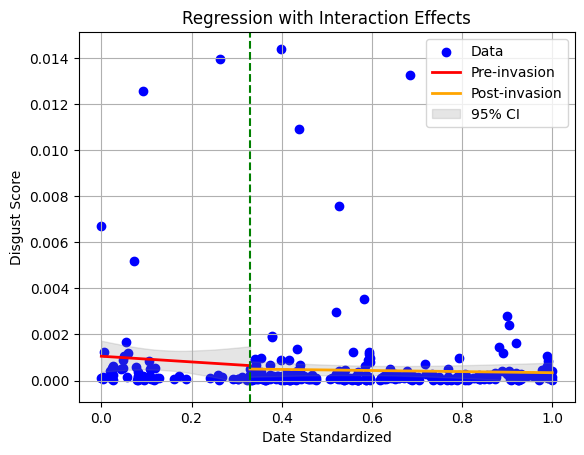

In [18]:
#Disgust IE Model

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'disgust_scores' are defined elsewhere
# Create the specific DataFrame
pre_gus_df = pd.DataFrame({
    'date': date_objects,
    'disgust_score': disgust_scores,
})

# Sort the DataFrame by the 'date' column
gus_df = pre_gus_df.sort_values(by='date')

# Standardize the 'date' column
gus_df['date_standardized'] = standardize_dates(gus_df['date'])

# Define the invasion date as a datetime object
invasion_date = pd.to_datetime('2022-02-24')

# Create a new variable representing the interaction between date and invasion date
gus_df['interaction'] = (gus_df['date'] > invasion_date).astype(int)

# Perform OLS regression with interaction term
X = gus_df[['date_standardized', 'interaction']].copy()
X = sm.add_constant(X)

# Using .loc to avoid SettingWithCopyWarning
X.loc[:, 'interaction_date'] = X['date_standardized'] * X['interaction']
y = gus_df['disgust_score']
interaction_model = sm.OLS(y, X).fit()

# Extract the coefficients for plotting
coefficients = interaction_model.params

# Display coefficients to check
print("Coefficients:")
print(coefficients)

# Calculate the confidence intervals for the coefficients
confidence_intervals = interaction_model.conf_int()
print("\nConfidence Intervals for Coefficients:")
print(confidence_intervals)

# Calculate the predicted values and confidence intervals based on the interaction model
predictions = interaction_model.get_prediction(X)
gus_df['interaction_prediction'] = predictions.predicted_mean
conf_int = predictions.conf_int()

# Plot the scatterplot
plt.scatter(gus_df['date_standardized'], y, color='blue', label='Data')

# Plot the pre-invasion regression line
pre_invasion = gus_df[gus_df['interaction'] == 0]
plt.plot(pre_invasion['date_standardized'], pre_invasion['interaction_prediction'], color='red', linewidth=2, label='Pre-invasion')

# Plot the post-invasion regression line
post_invasion = gus_df[gus_df['interaction'] == 1]
plt.plot(post_invasion['date_standardized'], post_invasion['interaction_prediction'], color='orange', linewidth=2, label='Post-invasion')

# Plot the confidence intervals
plt.fill_between(gus_df['date_standardized'], conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='95% CI')

# Plot a vertical dotted green line at the invasion date
plt.axvline(x=standardize_dates(pd.Series([invasion_date]), gus_df['date'].min(), gus_df['date'].max()).values[0], color='green', linestyle='--')

plt.title('Regression with Interaction Effects')
plt.xlabel('Date Standardized')
plt.ylabel('Disgust Score')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\sasha\AppData\Local\Temp\ipykernel_4184\2665337031.py:27: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


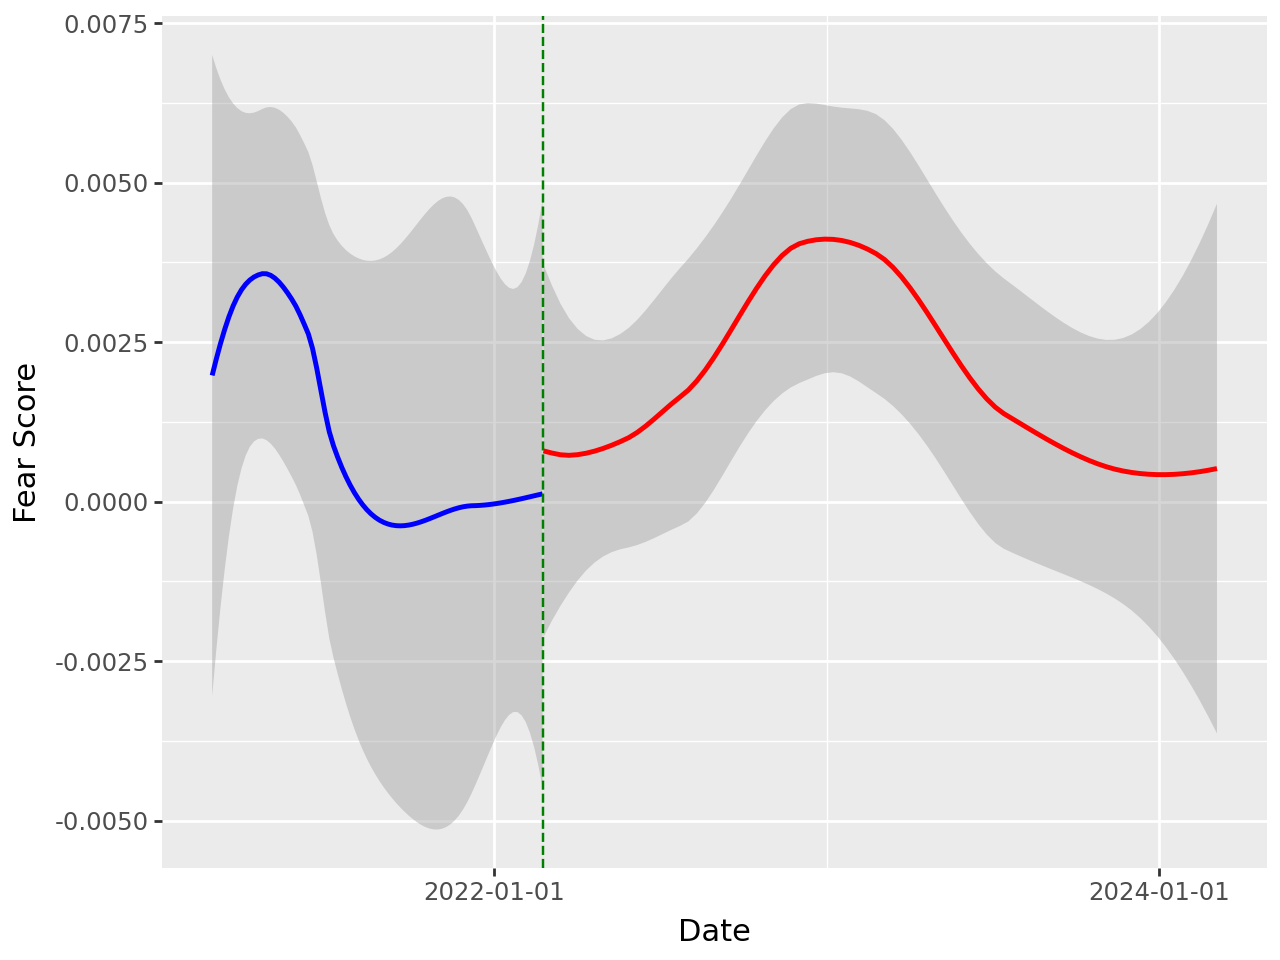

In [53]:
#GGPLOT w LOESS smooothing - Fear

# Assuming 'date_objects' and 'emotion_scores' are defined elsewhere
# Create the specific DataFrame
pre_fear_df = pd.DataFrame({
    'date': date_objects,
    'fear_score': fear_scores,
})

# Sort the DataFrame by the 'date' column
fear_df = pre_fear_df.sort_values(by='date')

# Add a column for date_objects and set it to a range of dates based on the length of your emotion scores
fear_df['date_objects'] = pd.date_range(start='2021-02-24', periods=len(fear_df), freq='D')

# Define the invasion date
invasion_date = '2022-02-24'

# Plotting with LOESS smoothing for before and after invasion on the same graph
plot = ggplot(fear_df, aes(x='date', y='fear_score')) + \
       geom_smooth(data=fear_df[fear_df['date'] < invasion_date], method='loess', se=True, color='blue') + \
       geom_smooth(data=fear_df[fear_df['date'] >= invasion_date], method='loess', se=True, color='red') + \
       geom_vline(xintercept=invasion_date, linetype='dashed', color='green') + \
       labs(x='Date', y='Fear Score')

# Show the plot
print(plot)

In [36]:
#Fear OLS Regression

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    # Avoid division by zero if all dates are the same
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'fear_scores' are defined elsewhere
# Create the specific DataFrame
pre_fear_df = pd.DataFrame({
    'date': date_objects,
    'fear_score': fear_scores,
})

# Sort the DataFrame by the 'date' column
fear_df = pre_fear_df.sort_values(by='date')

# Standardize the 'date' column
fear_df['date_standardized'] = standardize_dates(fear_df['date'])

# Perform OLS regression
X = fear_df['date_standardized']
X = sm.add_constant(X)
y = fear_df['fear_score']
model = sm.OLS(y, X).fit()

# Display model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             fear_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1628
Date:                Mon, 20 May 2024   Prob (F-statistic):              0.687
Time:                        20:45:43   Log-Likelihood:                 1114.7
No. Observations:                 336   AIC:                            -2225.
Df Residuals:                     334   BIC:                            -2218.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0020      0.00

Coefficients:
const                0.003315
date_standardized   -0.011134
interaction         -0.001521
interaction_date     0.010795
dtype: float64

Confidence Intervals for Coefficients:
                          0         1
const             -0.000156  0.006786
date_standardized -0.030553  0.008286
interaction       -0.006259  0.003217
interaction_date  -0.009265  0.030856


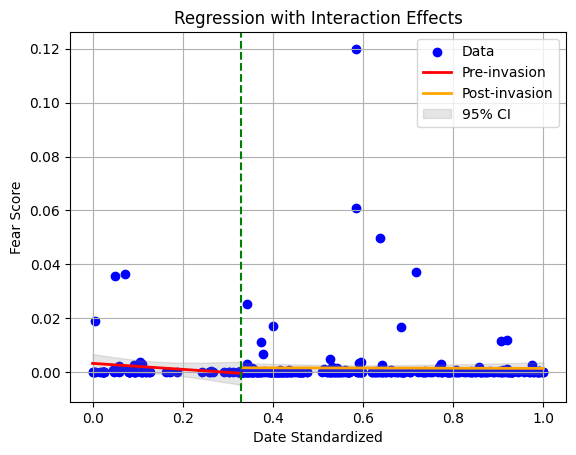

In [19]:
#Fear IE Model

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define the standardize_dates function
def standardize_dates(dates, min_date=None, max_date=None):
    if min_date is None:
        min_date = dates.min()
    if max_date is None:
        max_date = dates.max()
    
    if min_date == max_date:
        return np.zeros_like(dates, dtype=float)
    
    standardized_dates = (dates - min_date) / (max_date - min_date)
    return standardized_dates

# Assuming 'date_objects' and 'fear_scores' are defined elsewhere
# Create the specific DataFrame
pre_fear_df = pd.DataFrame({
    'date': date_objects,
    'fear_score': fear_scores,
})

# Sort the DataFrame by the 'date' column
fear_df = pre_fear_df.sort_values(by='date')

# Standardize the 'date' column
fear_df['date_standardized'] = standardize_dates(fear_df['date'])

# Define the invasion date as a datetime object
invasion_date = pd.to_datetime('2022-02-24')

# Create a new variable representing the interaction between date and invasion date
fear_df['interaction'] = (fear_df['date'] > invasion_date).astype(int)

# Perform OLS regression with interaction term
X = fear_df[['date_standardized', 'interaction']].copy()
X = sm.add_constant(X)

# Using .loc to avoid SettingWithCopyWarning
X.loc[:, 'interaction_date'] = X['date_standardized'] * X['interaction']
y = fear_df['fear_score']
interaction_model = sm.OLS(y, X).fit()

# Extract the coefficients for plotting
coefficients = interaction_model.params

# Display coefficients to check
print("Coefficients:")
print(coefficients)

# Calculate the confidence intervals for the coefficients
confidence_intervals = interaction_model.conf_int()
print("\nConfidence Intervals for Coefficients:")
print(confidence_intervals)

# Calculate the predicted values and confidence intervals based on the interaction model
predictions = interaction_model.get_prediction(X)
fear_df['interaction_prediction'] = predictions.predicted_mean
conf_int = predictions.conf_int()

# Plot the scatterplot
plt.scatter(fear_df['date_standardized'], y, color='blue', label='Data')

# Plot the pre-invasion regression line
pre_invasion = fear_df[fear_df['interaction'] == 0]
plt.plot(pre_invasion['date_standardized'], pre_invasion['interaction_prediction'], color='red', linewidth=2, label='Pre-invasion')

# Plot the post-invasion regression line
post_invasion = fear_df[fear_df['interaction'] == 1]
plt.plot(post_invasion['date_standardized'], post_invasion['interaction_prediction'], color='orange', linewidth=2, label='Post-invasion')

# Plot the confidence intervals
plt.fill_between(fear_df['date_standardized'], conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='95% CI')

# Plot a vertical dotted green line at the invasion date
plt.axvline(x=standardize_dates(pd.Series([invasion_date]), fear_df['date'].min(), fear_df['date'].max()).values[0], color='green', linestyle='--')

plt.title('Regression with Interaction Effects')
plt.xlabel('Date Standardized')
plt.ylabel('Fear Score')
plt.legend()
plt.grid(True)
plt.show()
